In [1]:
# --- Basic setup ---
import pandas as pd
import numpy as np
import torch
from volsense_core.forecasters.forecaster_api import VolSenseForecaster

# --- Utility inspection helpers ---
def inspect_df(df, name):
    print(f"\n🧩 {name} Shape: {df.shape}")
    print(df.head(3))
    print("\nColumns:", list(df.columns))
    print("Unique tickers:", df['ticker'].unique())
    print("Unique horizons:", df['horizon'].unique())
    print("Missing values summary:")
    print(df.isna().sum())

In [2]:
from volsense_core.data_fetching.fetch_yf import (fetch_ohlcv,
compute_returns_vol)
from volsense_core.data_fetching.multi_fetch import (fetch_multi_ohlcv, 
build_multi_dataset)
from volsense_core.data_fetching.feature_engineering import build_features

TICKER = "AAPL"
TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "META", "NVDA", "JPM"]

df_ohlcv_multi_raw = fetch_multi_ohlcv(TICKERS, start="2015-01-01", end="2025-12-31")
df_ohlcv_single_raw = fetch_multi_ohlcv([TICKER], start="2015-01-01", end="2025-12-31")


multi_df = build_multi_dataset(df_ohlcv_multi_raw, window=15)
single_df = build_multi_dataset(df_ohlcv_single_raw, window=15)

multi_df = build_features(multi_df)
single_df = build_features(single_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
# Instantiate BaseLSTM forecaster
lstm_forecaster = VolSenseForecaster(
    method="lstm",
    device="cuda" if torch.cuda.is_available() else "cpu",
    window=30,
    horizons=[1, 5, 10],
    val_start="2023-01-01",
    epochs=2  # keep short for testing
)

# Fit
lstm_forecaster.fit(single_df)

# Predict in eval mode
df_lstm_eval = lstm_forecaster.predict(mode="eval")
inspect_df(df_lstm_eval, "BaseLSTM Eval")

# Confirm realized vs forecast scale consistency
print("Forecast mean (realized scale):", df_lstm_eval['forecast_vol'].mean())
print("Realized mean:", df_lstm_eval['realized_vol'].mean())


🧩 Training BaseLSTM Forecaster...
⚠️ Dropping constant features: ['market_stress', 'market_stress_1d_lag']
⚠️ Dropping constant features: ['market_stress', 'market_stress_1d_lag']
Epoch 1/2 | LR: 2.51e-04 | Train: 1.034995 | Val: 0.695578
Epoch 2/2 | LR: 1.00e-06 | Train: 0.655608 | Val: 0.546367

🧩 BaseLSTM Eval Shape: (2001, 7)
      asof_date       date ticker  horizon  forecast_vol  realized_vol  \
0    2023-02-14 2023-02-15   AAPL        1      1.269052      1.305544   
667  2023-02-14 2023-02-21   AAPL        5      1.274242      1.327400   
1334 2023-02-14 2023-02-28   AAPL       10      1.285041      1.220052   

         model  
0     BaseLSTM  
667   BaseLSTM  
1334  BaseLSTM  

Columns: ['asof_date', 'date', 'ticker', 'horizon', 'forecast_vol', 'realized_vol', 'model']
Unique tickers: ['AAPL']
Unique horizons: [ 1  5 10]
Missing values summary:
asof_date       0
date            0
ticker          0
horizon         0
forecast_vol    0
realized_vol    0
model           0
dtype:

In [8]:
df_lstm_eval

,asof_date,date,ticker,horizon,forecast_vol,realized_vol,model
0,2023-02-14,2023-02-15,AAPL,1,1.274105,1.305544,BaseLSTM
667,2023-02-14,2023-02-21,AAPL,5,1.281633,1.327400,BaseLSTM
1334,2023-02-14,2023-02-28,AAPL,10,1.318262,1.220053,BaseLSTM
1,2023-02-15,2023-02-16,AAPL,1,1.259598,1.312764,BaseLSTM
668,2023-02-15,2023-02-22,AAPL,5,1.268566,1.326077,BaseLSTM
...,...,...,...,...,...,...,...
1332,2025-10-09,2025-10-16,AAPL,5,1.253447,1.192167,BaseLSTM
1999,2025-10-09,2025-10-23,AAPL,10,1.283145,1.304568,BaseLSTM
666,2025-10-10,2025-10-13,AAPL,1,1.252815,1.213201,BaseLSTM
1333,2025-10-10,2025-10-17,AAPL,5,1.256261,1.217339,BaseLSTM


In [3]:
# Instantiate Global model
global_forecaster = VolSenseForecaster(
    method="global_lstm",
    device="cuda" if torch.cuda.is_available() else "cpu",
    window=30,
    horizons=[1, 5, 10],
    epochs=2,
    val_start="2023-01-01"
)

# Fit on multi-ticker data
global_forecaster.fit(multi_df)

# Predict in eval mode
df_global_eval = global_forecaster.predict(data=multi_df, mode="eval")
inspect_df(df_global_eval, "GlobalVolForecaster Eval")

# Cross-ticker coverage check
print("\nTicker distribution:")
print(df_global_eval['ticker'].value_counts().head())

# Sanity check on scales
print("Forecast mean (realized scale):", df_global_eval['forecast_vol'].mean())
print("Realized mean:", df_global_eval['realized_vol'].mean())


🌐 Training GlobalVolForecaster...

🚀 Training GlobalVolForecaster on 8 tickers...

Epoch 1/2 | Train Loss: 0.4791 | Val Loss: 0.1634
Epoch 2/2 | Train Loss: 0.2285 | Val Loss: 0.1668

✅ Training complete with feature set: ['return']



Rolling eval forecasts: 100%|██████████| 8/8 [05:29<00:00, 41.17s/it]


✅ GlobalVolForecaster realized-aligned evaluation complete (64096 rows).

🧩 GlobalVolForecaster Eval Shape: (64096, 7)
   asof_date       date ticker  horizon  forecast_vol  realized_vol  \
0 2015-03-09 2015-03-10   AAPL        1      1.015674      0.219604   
1 2015-03-09 2015-03-16   AAPL        5      0.591533      0.209996   
2 2015-03-09 2015-03-23   AAPL       10      0.804515      0.204029   

                 model  
0  GlobalVolForecaster  
1  GlobalVolForecaster  
2  GlobalVolForecaster  

Columns: ['asof_date', 'date', 'ticker', 'horizon', 'forecast_vol', 'realized_vol', 'model']
Unique tickers: ['AAPL' 'AMZN' 'GOOG' 'JPM' 'META' 'MSFT' 'NVDA' 'TSLA']
Unique horizons: [ 1  5 10]
Missing values summary:
asof_date       0
date            0
ticker          0
horizon         0
forecast_vol    0
realized_vol    0
model           0
dtype: int64

Ticker distribution:
ticker
AAPL    8012
AMZN    8012
GOOG    8012
JPM     8012
META    8012
Name: count, dtype: int64
Forecast mean (rea

In [3]:
# Instantiate and fit GARCH
garch_forecaster = VolSenseForecaster(
    method="garch",
    p=1, q=1, dist="t"
)
garch_forecaster.fit(multi_df)

# Predict (Eval Mode)
df_garch_eval = garch_forecaster.predict(mode="eval")
inspect_df(df_garch_eval, "GARCH Eval")

# Quick consistency check
assert (df_garch_eval['forecast_vol'] > 0).all(), "GARCH returned invalid vol"

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AAPL (21640 obs).

🧩 GARCH Eval Shape: (21610, 7)
   asof_date       date ticker  horizon  forecast_vol  realized_vol  model
0 2015-03-10 2015-03-11   AAPL        1      0.206448      0.218625  GARCH
1 2015-03-11 2015-03-12   AAPL        1      0.206448      0.229095  GARCH
2 2015-03-12 2015-03-13   AAPL        1      0.206448      0.227998  GARCH

Columns: ['asof_date', 'date', 'ticker', 'horizon', 'forecast_vol', 'realized_vol', 'model']
Unique tickers: ['AAPL']
Unique horizons: [1]
Missing values summary:
asof_date       0
date            0
ticker          0
horizon         0
forecast_vol    0
realized_vol    0
model           0
dtype: int64


In [9]:
# --- Your Evaluation Framework ---
from volsense_core.evaluation.evaluation import ModelEvaluator
import matplotlib.pyplot as plt

# --- Display Options ---
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-darkgrid")

# ✅ Confirm available eval DataFrames
for name, df in {
    "BaseLSTM": df_lstm_eval,
    "GlobalVolForecaster": df_global_eval,
    "GARCH": df_garch_eval,
}.items():
    print(f"{name:25s} -> {len(df):8,d} rows | Columns: {list(df.columns)}")


BaseLSTM                  ->    2,001 rows | Columns: ['asof_date', 'date', 'ticker', 'horizon', 'forecast_vol', 'realized_vol', 'model']
GlobalVolForecaster       ->   64,096 rows | Columns: ['asof_date', 'date', 'ticker', 'horizon', 'forecast_vol', 'realized_vol', 'model']
GARCH                     ->   21,610 rows | Columns: ['asof_date', 'date', 'ticker', 'horizon', 'forecast_vol', 'realized_vol', 'model']


In [10]:
# Instantiate unified evaluation objects
eval_baselstm = ModelEvaluator(df_lstm_eval)
eval_global = ModelEvaluator(df_global_eval)
eval_garch = ModelEvaluator(df_garch_eval)

# Quick metadata check
print("✅ Evaluation objects initialized successfully.")
print(f"GlobalVolForecaster tickers: {eval_global.df['ticker'].nunique()}")
print(f"Horizons: {eval_global.df['horizon'].unique()}")

✅ Evaluation objects initialized successfully.
GlobalVolForecaster tickers: 8
Horizons: [ 1  5 10]


In [4]:
from volsense_core.evaluation.evaluation import ModelEvaluator
eval_global = ModelEvaluator(df_global_eval)
eval_global.compute_metrics()

,ticker,horizon,RMSE,MAE,MAPE,R2,Corr,DW,ACF_SumSq
0,AAPL,1,0.778912,0.768733,380.735579,-33.191330,0.451292,0.001269,6.990694
1,AAPL,5,0.357652,0.342346,178.126687,-6.198488,-0.680588,0.006034,7.083941
2,AAPL,10,0.560967,0.549445,277.212835,-16.680736,0.409038,0.002460,7.010939
3,AMZN,1,0.996585,0.986493,437.629433,-46.663836,0.349402,0.001289,6.249895
4,AMZN,5,0.297984,0.274150,135.478833,-3.257159,-0.443128,0.014460,6.360997
5,AMZN,10,0.540544,0.521370,242.588870,-12.992093,0.417506,0.004408,6.262599
6,GOOG,1,0.648332,0.636800,319.418800,-26.109453,0.384251,0.002438,6.228580
7,GOOG,5,0.357360,0.340102,179.682310,-7.226414,-0.573057,0.008001,6.356044
8,GOOG,10,0.526364,0.513033,261.457346,-16.820852,0.471706,0.003696,6.267009
9,JPM,1,0.851264,0.842885,466.000654,-33.657997,0.571771,0.001026,7.195524


In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np

g = df_global_eval[(df_global_eval.ticker == "AAPL") & (df_global_eval.horizon == 1)].dropna()
resid = g["realized_vol"] - g["forecast_vol"]

print("Residual length:", len(resid))
print("Residual sample:", resid[:5].to_list())

# --- Direct Ljung-Box test ---
lb_test = acorr_ljungbox(resid, lags=10, return_df=True)
print(lb_test)


Residual length: 2675
Residual sample: [-0.28638057585398957, -0.28022910460321804, -0.26200337179866856, -0.2687940615395982, -0.2996452740142498]
         lb_stat  lb_pvalue
1    2559.858264        0.0
2    4985.097265        0.0
3    7267.848456        0.0
4    9403.493576        0.0
5   11379.795484        0.0
6   13192.478058        0.0
7   14839.878856        0.0
8   16332.346055        0.0
9   17670.108023        0.0
10  18861.260197        0.0


In [7]:
lb_stat, lb_p = acorr_ljungbox(resid, lags=10, return_df=False)
print("Raw p-values:", lb_p)

Raw p-values: lb_pvalue


In [13]:
eval_global.compute_metrics()

,ticker,horizon,RMSE,MAE,MAPE,R2,Corr,DW,LjungBox_p
0,AAPL,1,0.582419,0.571067,287.385878,-18.116605,0.582583,0.002267,0.0
1,AAPL,5,0.471553,0.458901,234.149621,-11.513560,-0.338565,0.003484,0.0
2,AAPL,10,0.434109,0.420754,215.928472,-9.588227,-0.276441,0.004112,0.0
3,AMZN,1,0.527208,0.507417,236.886220,-12.339033,0.407001,0.004609,0.0
4,AMZN,5,0.422411,0.399114,191.025273,-7.554675,-0.336642,0.007203,0.0
5,AMZN,10,0.378326,0.354555,171.518489,-5.854130,-0.194506,0.008991,0.0
6,GOOG,1,0.492298,0.478275,245.099032,-14.630788,0.428025,0.004212,0.0
7,GOOG,5,0.444347,0.429022,222.088831,-11.718732,-0.296484,0.005179,0.0
8,GOOG,10,0.367560,0.350571,184.702823,-7.689847,-0.194863,0.007577,0.0
9,JPM,1,0.619735,0.609871,341.704847,-17.369089,0.623022,0.001936,0.0


In [30]:
eval_global.compute_metrics()["LjungBox_p"].describe()  

count    24.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: LjungBox_p, dtype: float64


🚀 Running full evaluation for UnknownModel

📈 Horizon-Level Summary for UnknownModel


,horizon,RMSE,MAE,MAPE,R2,Corr,DW
0,1,0.5792,0.5610,247.0739,-12.7649,0.4097,0.0049
1,5,0.4396,0.4188,191.8719,-7.4371,-0.2826,0.0093
2,10,0.3586,0.3358,157.0182,-4.7720,-0.1247,0.0148


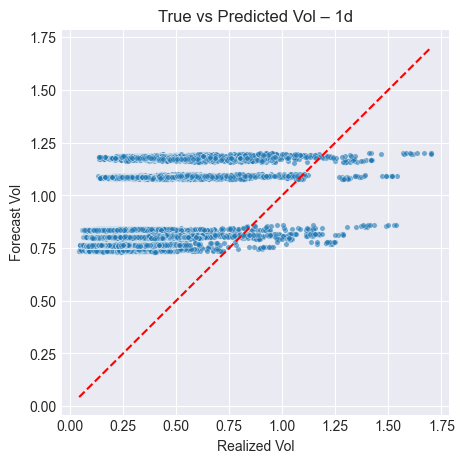

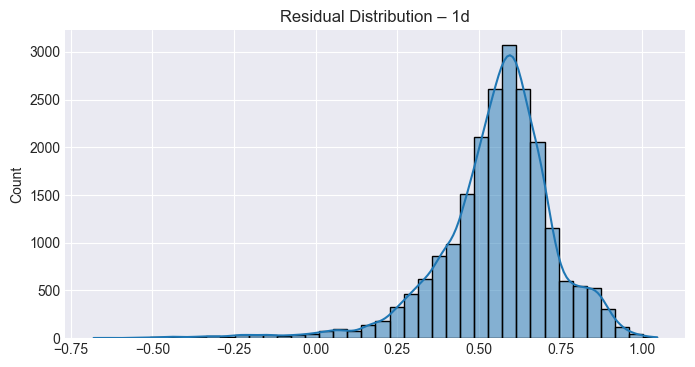

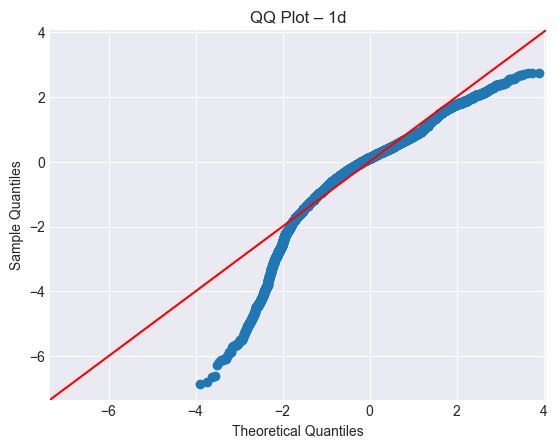

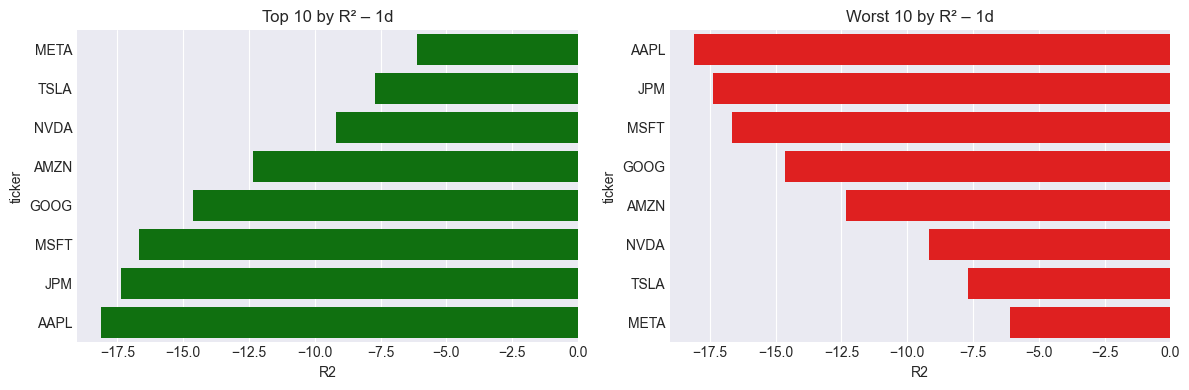

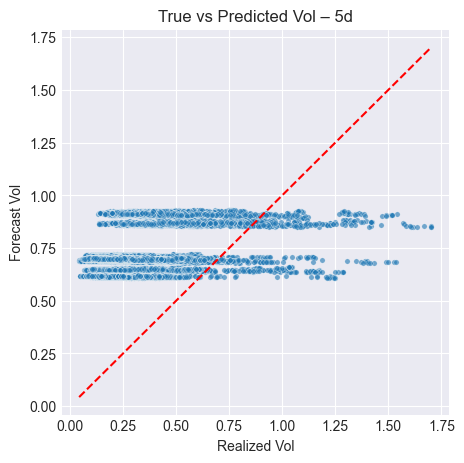

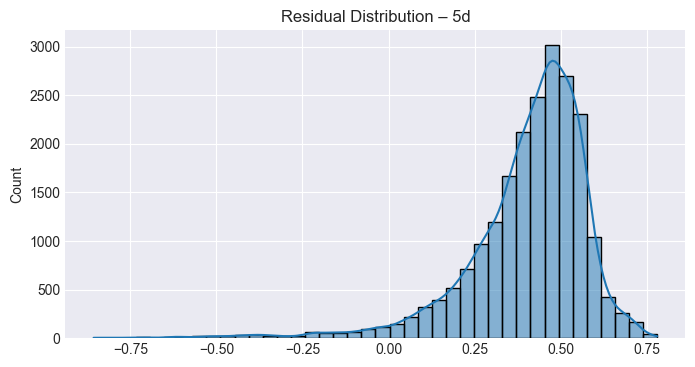

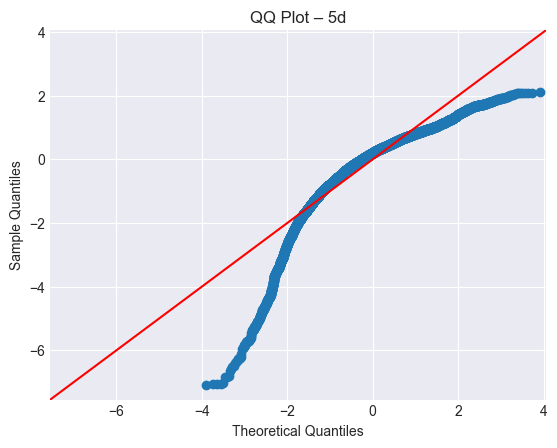

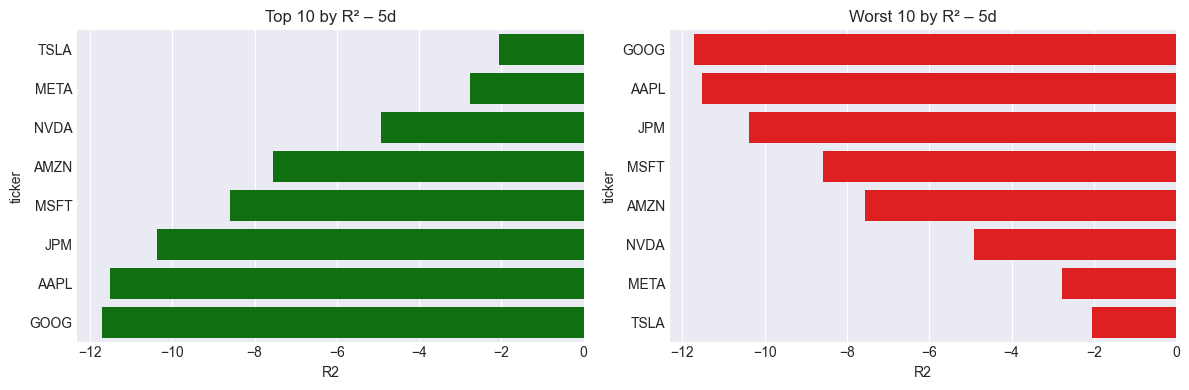

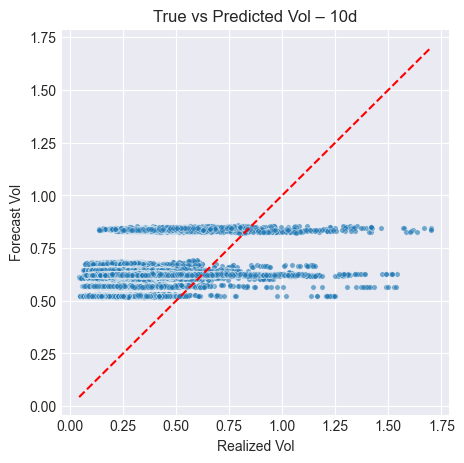

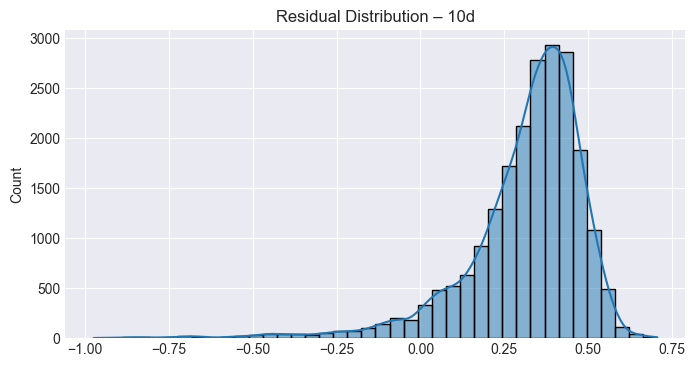

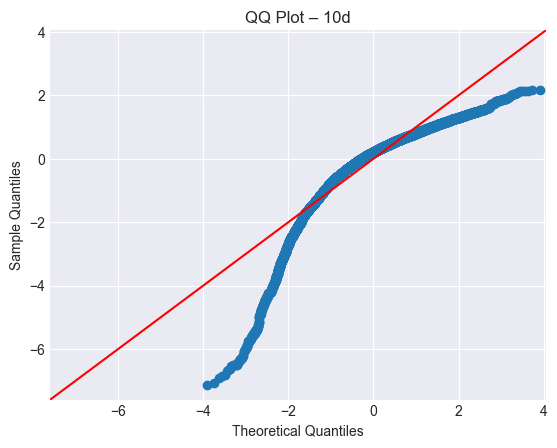

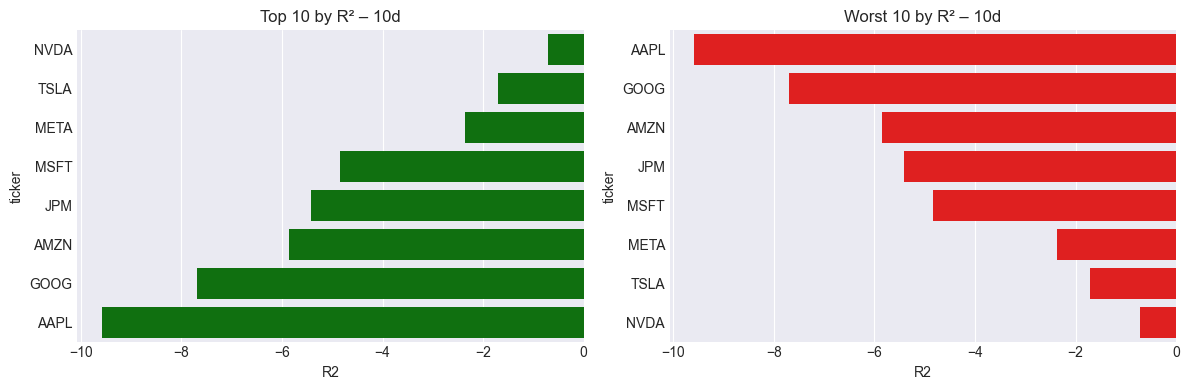

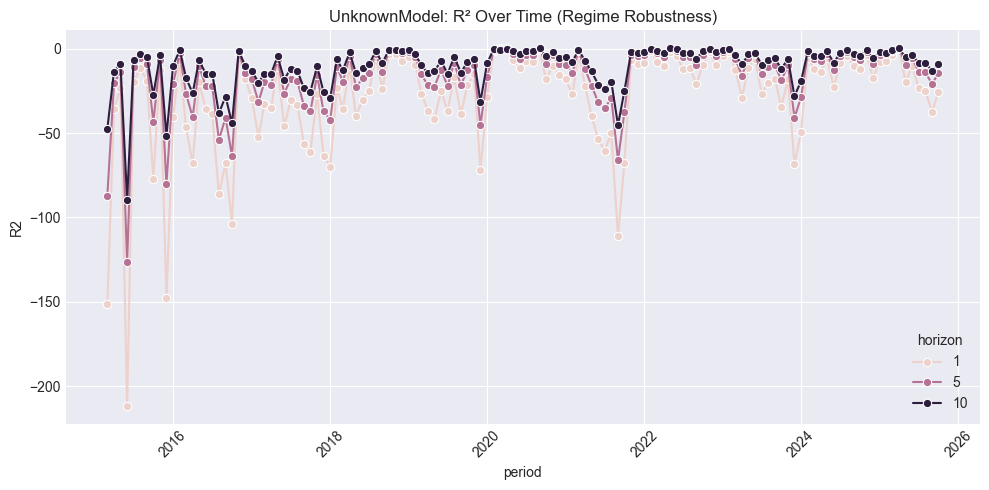

✅ Evaluation complete.


(   ticker  horizon      RMSE       MAE        MAPE         R2      Corr  \
 0    AAPL        1  0.582419  0.571067  287.385878 -18.116605  0.582583   
 1    AAPL        5  0.471553  0.458901  234.149621 -11.513560 -0.338565   
 2    AAPL       10  0.434109  0.420754  215.928472  -9.588227 -0.276441   
 3    AMZN        1  0.527208  0.507417  236.886220 -12.339033  0.407001   
 4    AMZN        5  0.422411  0.399114  191.025273  -7.554675 -0.336642   
 5    AMZN       10  0.378326  0.354555  171.518489  -5.854130 -0.194506   
 6    GOOG        1  0.492298  0.478275  245.099032 -14.630788  0.428025   
 7    GOOG        5  0.444347  0.429022  222.088831 -11.718732 -0.296484   
 8    GOOG       10  0.367560  0.350571  184.702823  -7.689847 -0.194863   
 9     JPM        1  0.619735  0.609871  341.704847 -17.369089  0.623022   
 10    JPM        5  0.488137  0.476424  270.057497 -10.380107 -0.490202   
 11    JPM       10  0.366826  0.352457  202.408564  -5.415809 -0.208661   
 12   META  

In [28]:
eval_global.run_full_evaluation()